In [13]:
%pylab notebook

import pandas as pd
import numpy as np
from datetime import datetime
import lightgbm as gbm


Populating the interactive namespace from numpy and matplotlib


/Users/karper/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['var', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [14]:
def score(Y_pred, Y_true):
    E = np.sqrt(np.sum((Y_pred - Y_true)**2))
    L2pred = np.sqrt(np.sum(Y_pred**2))
    L2true = np.sqrt(np.sum(Y_true**2))
    
    return 2*E/(L2pred + L2true)

#
#   yp = yt*(1+alpha)
# . alpha = (yp-yt)/yt
#

def stat_score(Y_pred, Y_true):
    Y_pred = Y_pred.values
    Y_true = Y_true.values
    AYT = np.abs(Y_true)
    YTC = 0.5*(np.sign(AYT-10) + 1.0)
    YTZ = Y_true*YTC + 1*(1.0-YTC)
    E = YTC*(Y_pred- Y_true)/YTZ
    mu = np.mean(E)
    sigma = np.std(E)
    
    Q = np.percentile(E, q=[10, 25, 50, 75, 90])
    
    
    return mu, sigma



def get_E(Y_pred, Y_true):
    Y_pred = Y_pred.values
    Y_true = Y_true.values
    AYT = np.abs(Y_true)
    YTC = 0.5*(np.sign(AYT-10) + 1.0)
    YTZ = Y_true*YTC + 1*(1.0-YTC)
    E = YTC*(Y_pred- Y_true)/YTZ
    
    
    return E


In [15]:
class LGBMReg():
    
    def __init__(self):
        pass
                
    def fit(self,X, Y, T):
        self.output_tags = Y.columns
        self.estimator = {}
        for var in self.output_tags:
            self.estimator[var] = gbm.LGBMRegressor(n_estimators=100)

        TT = pd.to_datetime(T, unit='ms').values
        print('Training on ', TT[0], TT[-1])
        for var in self.output_tags:
            y = Y[var]
            self.estimator[var].fit(X, y)
            
    
    
    def predict(self, X, T):
        Ypred = pd.DataFrame()
        Ypred['timestamp'] = T
        for var in self.output_tags:
            Ypred[var] = self.estimator[var].predict(X.values)
        
        return Ypred
    

In [16]:
def run_scenario(data, input_tags, output_tags, window_size, train_to_time):
    train_condition = (data.timestamp < train_to_time)
    data_train = data[train_condition]
    data_test  = data[~train_condition]

    # Do the initial fit
    X_train = data_train[input_tags]
    Y_train = data_train[output_tags]
    T_train = data_train.timestamp
    
    gbmEst = LGBMReg()
    gbmEst.fit(X_train, Y_train, T_train)
    
    T_test = data_test.timestamp.values
    T = T_test
    DT = T[-1]-T[0]
    if(DT>window_size):
        dt_pred = np.arange(T[0], T[-1], window_size)
    else:
        dt_pred=[T[0]]


    Ypred = pd.DataFrame(columns=output_tags)
        
    for i in range(0, len(dt_pred)):
        t = dt_pred[i]
        t_next = np.minimum(T[-1], t+window_size)
        t_condition = (data_test.timestamp >= t) & (data_test.timestamp < t_next)
        Xpred  = data_test[input_tags]
        Xpred  = Xpred[t_condition]
        if(len(Xpred)<1):
            continue
            
        T_this = data_test[t_condition].timestamp
            
        Ypred_this = pd.DataFrame()
        Ypred_this['timestamp'] = T_this
        Ypred_this = gbmEst.predict(Xpred, T_this)
            
        Ypred = pd.concat([Ypred, Ypred_this])
            
        if(t_next==t+window_size):
            Ytrue  = data_test[output_tags]
            Ytrue  = Ytrue[t_condition]
            Y_train = pd.concat([Y_train, Ytrue])
            X_train = pd.concat([X_train, Xpred])
            gbmEst.fit(X_train, Y_train, T_this)
                            
    return Ypred
    
    
    
    
    
    

In [17]:
data = pd.read_csv('../data/d3_train.csv')

In [18]:
#data = data.drop(['SKAP_18SCSSV3205/BCH/10sSAMP|average', 'SKAP_18HPB320/BCH/10sSAMP|average'], axis=1)

In [19]:
time_cond = (data.timestamp > int(datetime(2014, 3, 1).timestamp()*1000))
data = data[time_cond]

In [20]:
output_columns = ['SKAP_18FI381-VFlLGas/Y/10sSAMP|average',
                  'SKAP_18FI381-VFlLH2O/Y/10sSAMP|average',
                  'SKAP_18FI381-VFlLOil/Y/10sSAMP|average']

output_data = data[output_columns]
input_data  = data.drop(output_columns, axis=1)
input_data  = input_data.drop(['timestamp','Unnamed: 0'], axis=1)
input_columns = list(input_data.columns.values)

In [21]:
wsize = int(1000*60*60*24*14)
rcond = (data.index < len(data)*0.6)
train_to_time = data[rcond].timestamp.values[-1]
Ypred = run_scenario(data, input_columns, output_columns, wsize, train_to_time)

Training on  2014-03-02T05:50:00.000000000 2015-08-03T07:10:00.000000000
Training on  2015-08-03T07:20:00.000000000 2015-08-17T07:10:00.000000000
Training on  2015-08-17T07:20:00.000000000 2015-08-27T18:30:00.000000000
Training on  2015-08-31T23:20:00.000000000 2015-09-12T17:30:00.000000000
Training on  2015-09-16T22:20:00.000000000 2015-09-23T21:40:00.000000000
Training on  2015-10-01T20:00:00.000000000 2015-10-12T07:10:00.000000000
Training on  2015-10-12T07:20:00.000000000 2015-10-21T19:50:00.000000000
Training on  2015-10-27T20:10:00.000000000 2015-11-06T22:50:00.000000000
Training on  2015-11-10T22:00:00.000000000 2015-11-22T20:00:00.000000000
Training on  2015-11-24T00:00:00.000000000 2015-12-06T20:00:00.000000000
Training on  2015-12-10T22:40:00.000000000 2015-12-21T07:10:00.000000000
Training on  2015-12-21T07:20:00.000000000 2016-01-04T07:10:00.000000000
Training on  2016-01-04T07:20:00.000000000 2016-01-13T20:50:00.000000000
Training on  2016-01-19T22:00:00.000000000 2016-02-

<IPython.core.display.Javascript object>


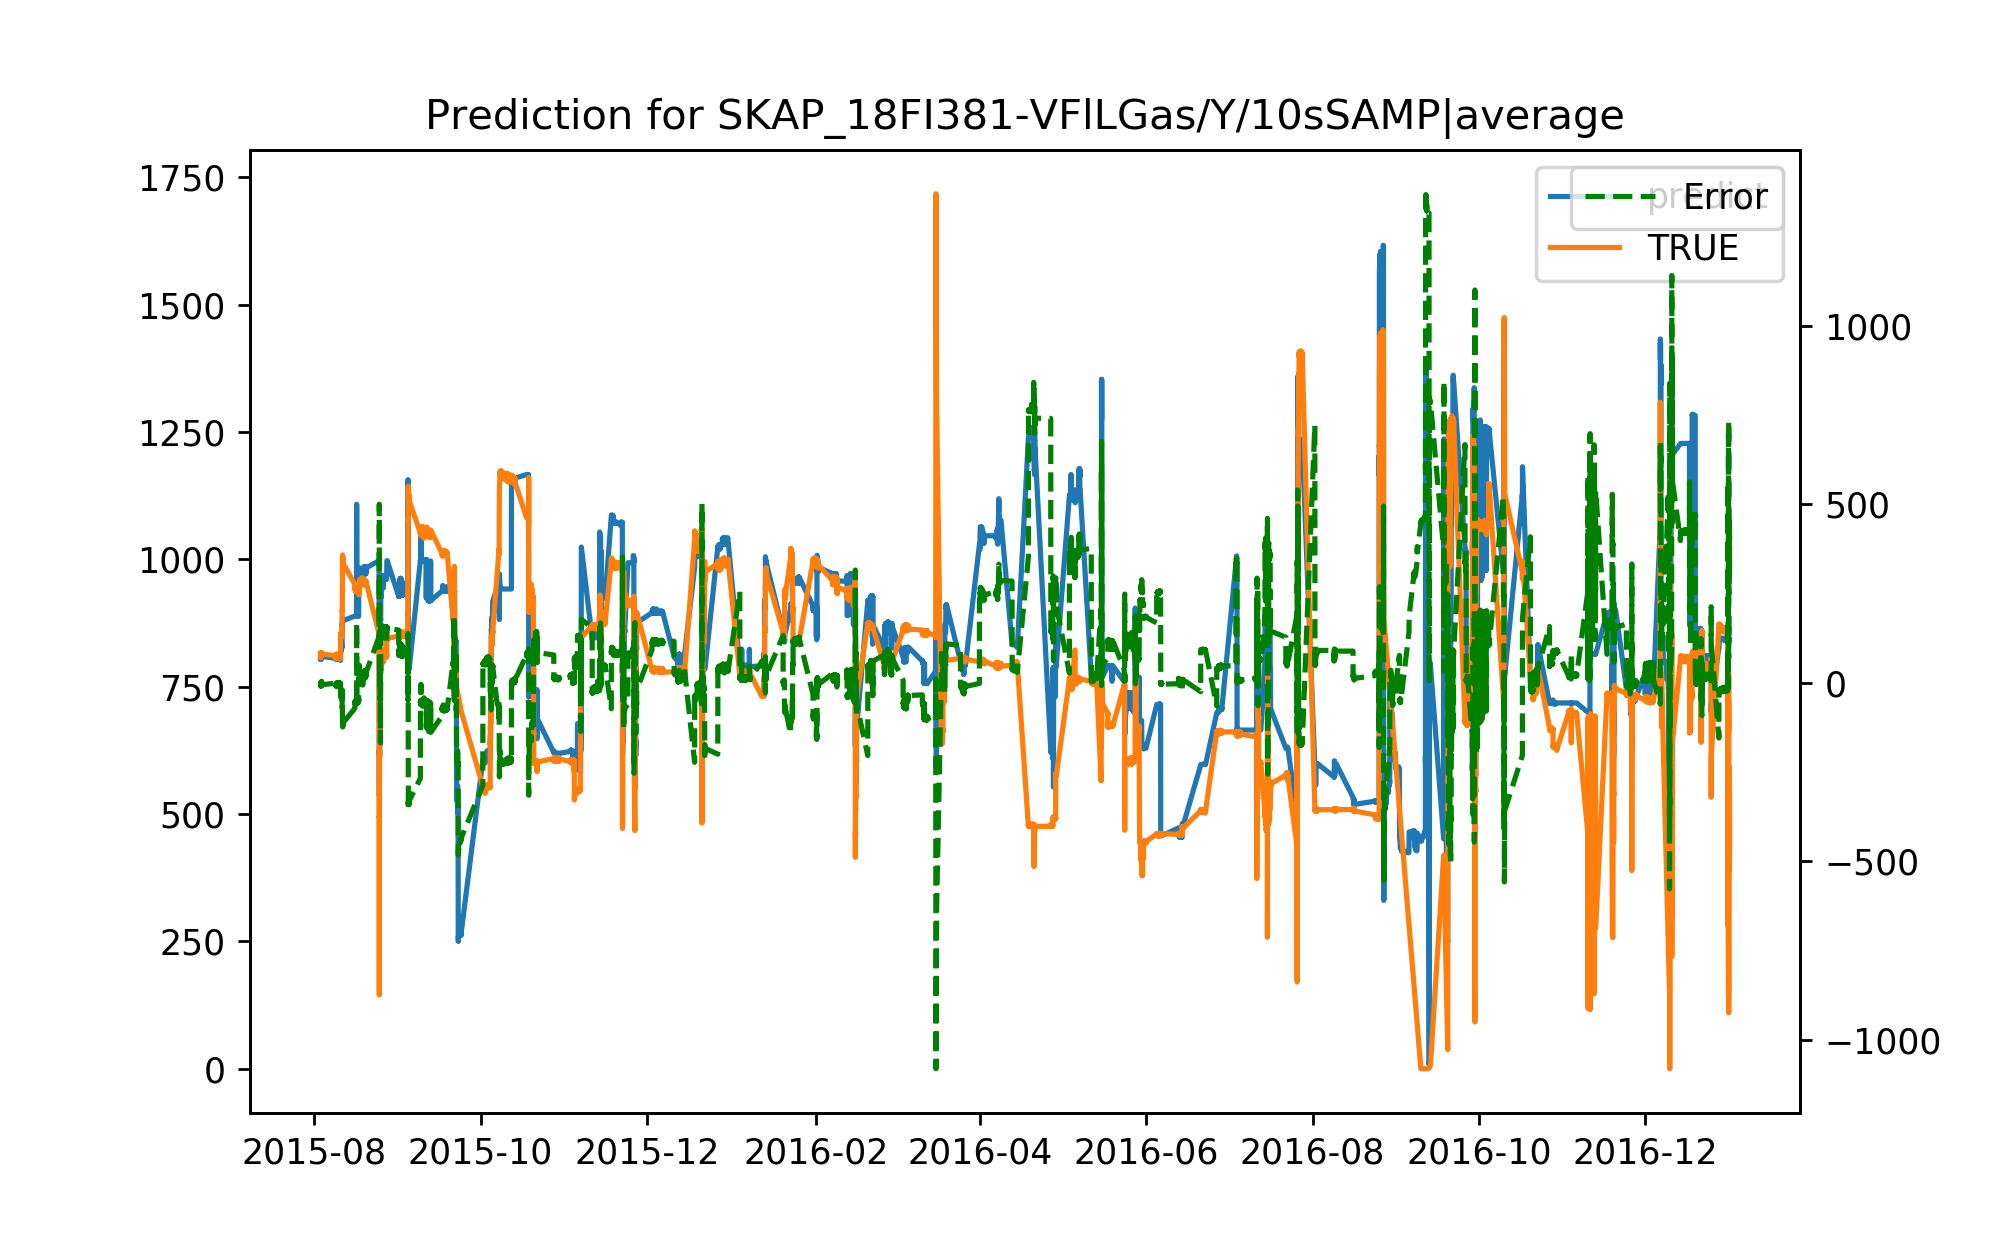

<IPython.core.display.Javascript object>


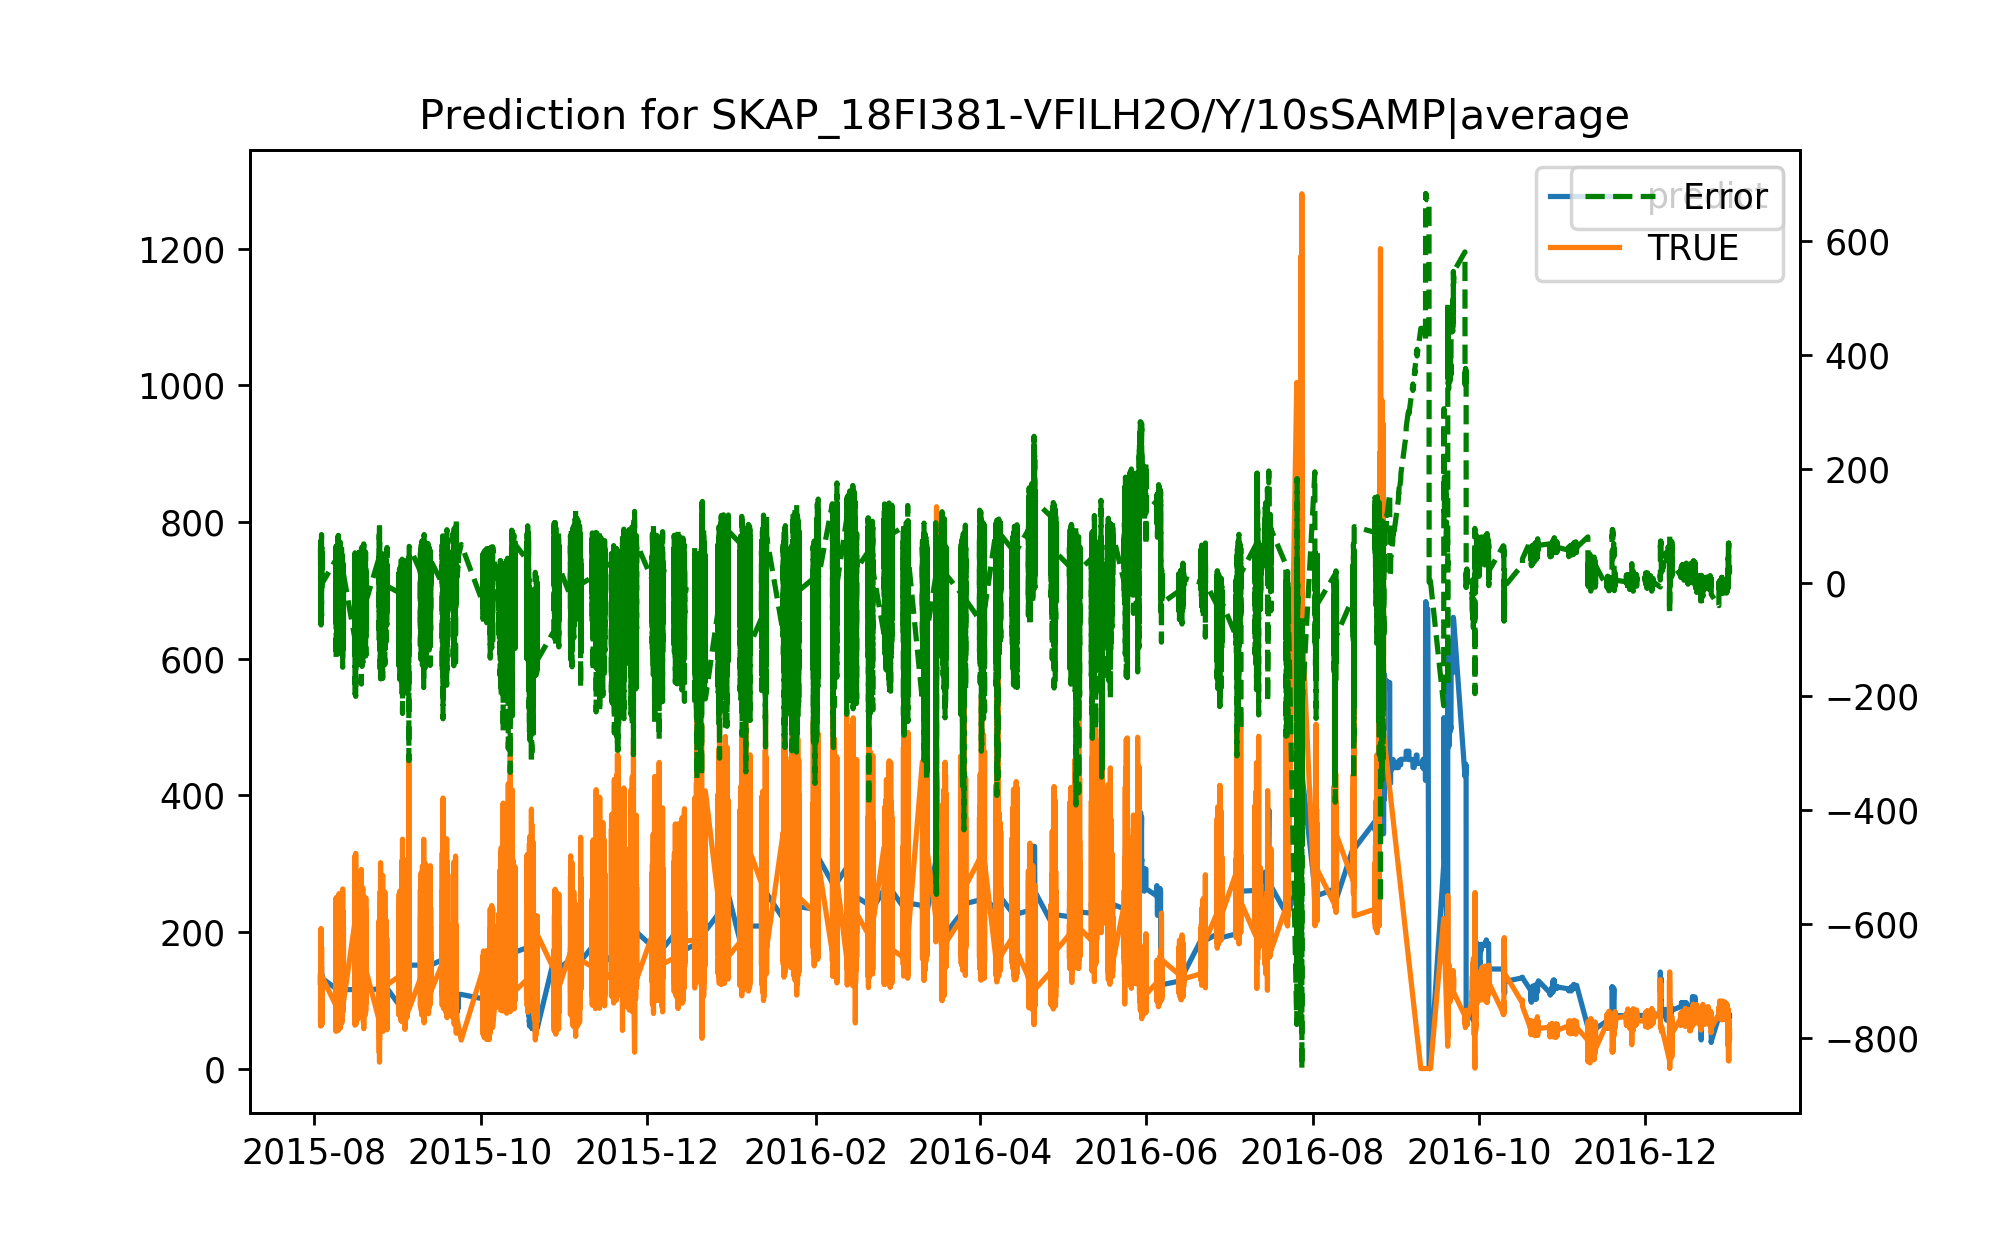

<IPython.core.display.Javascript object>


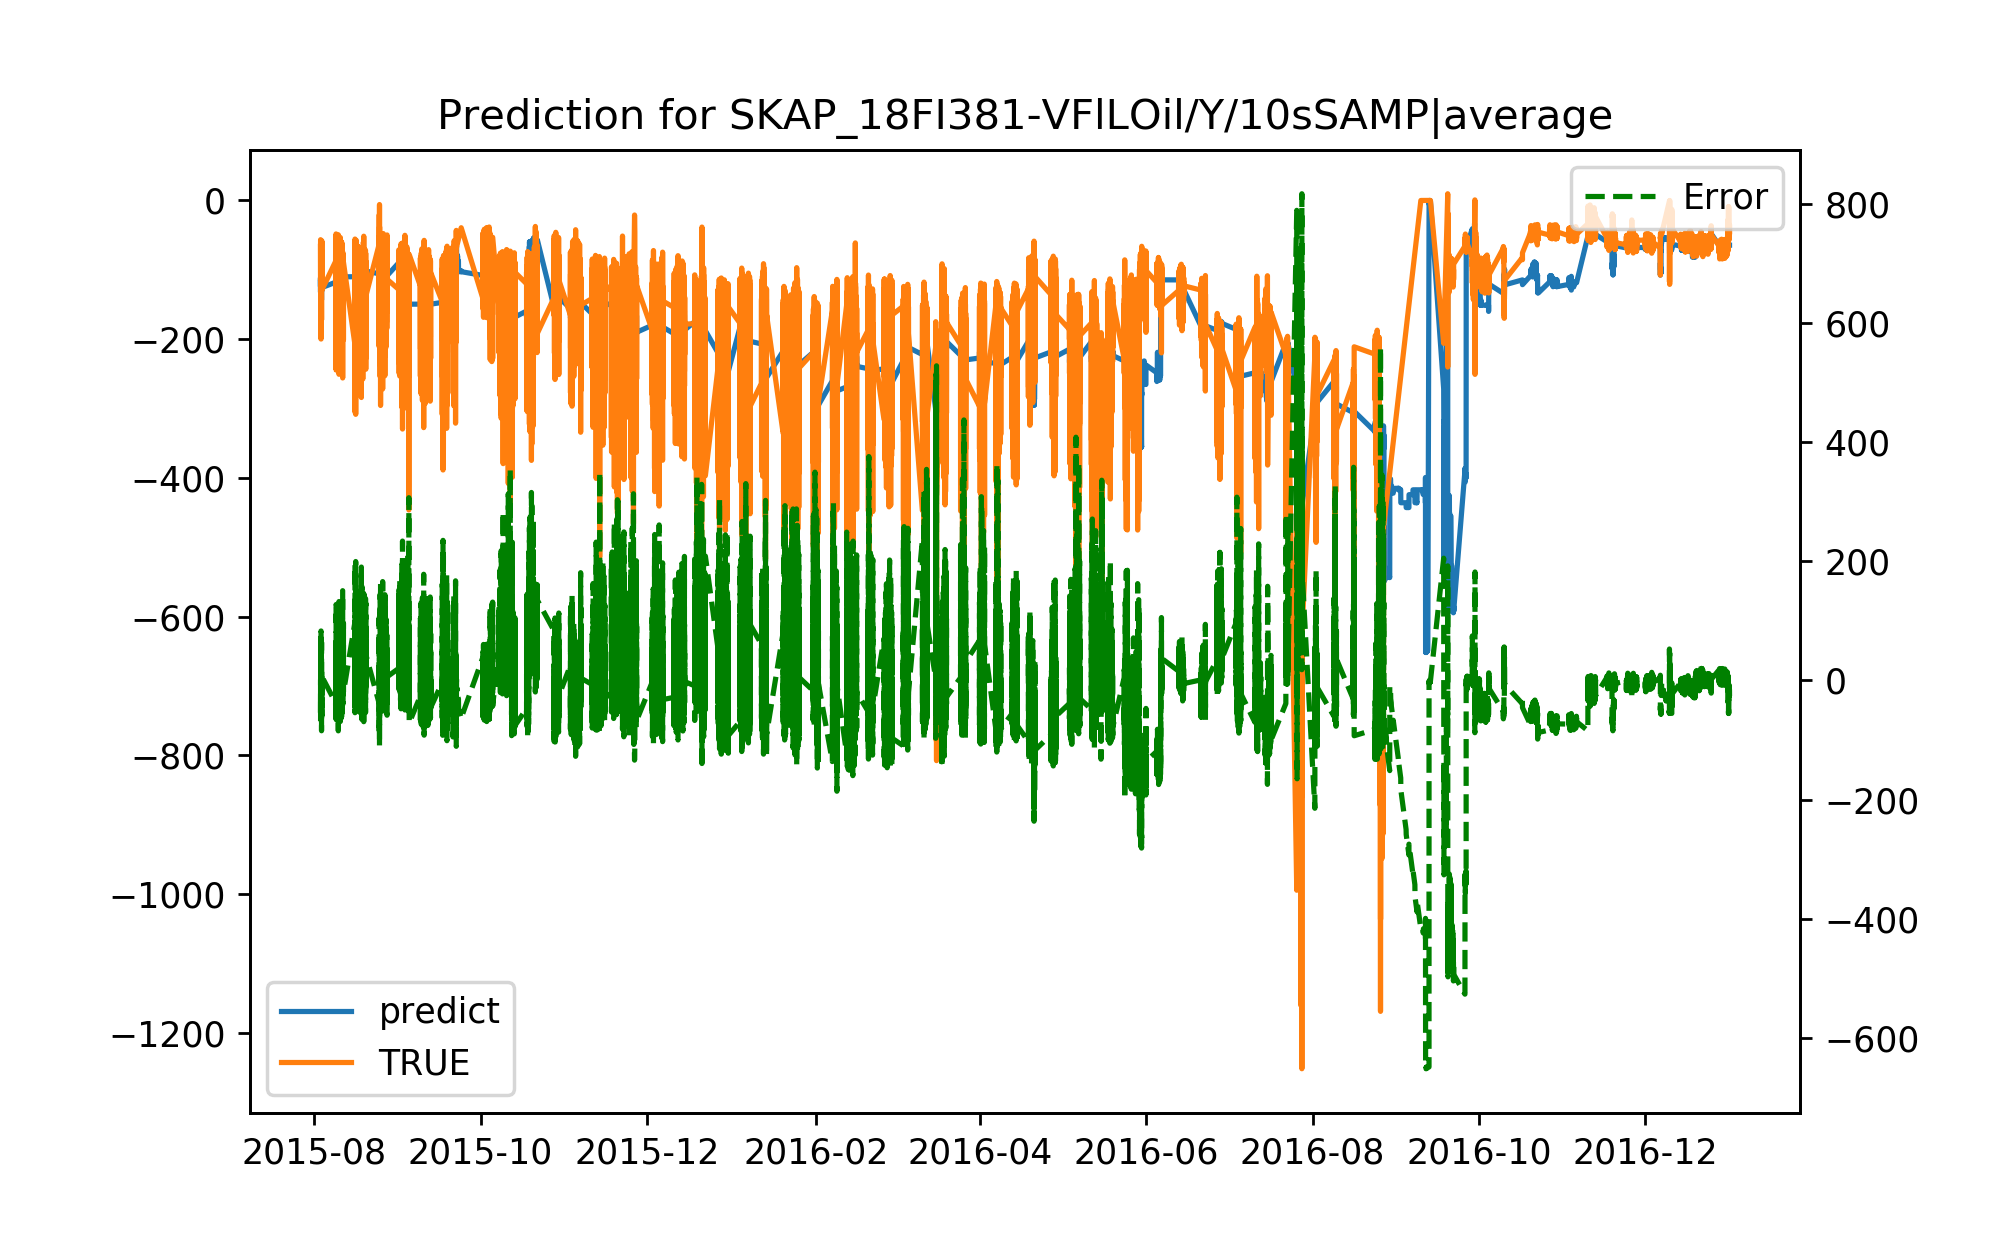

<IPython.core.display.Javascript object>


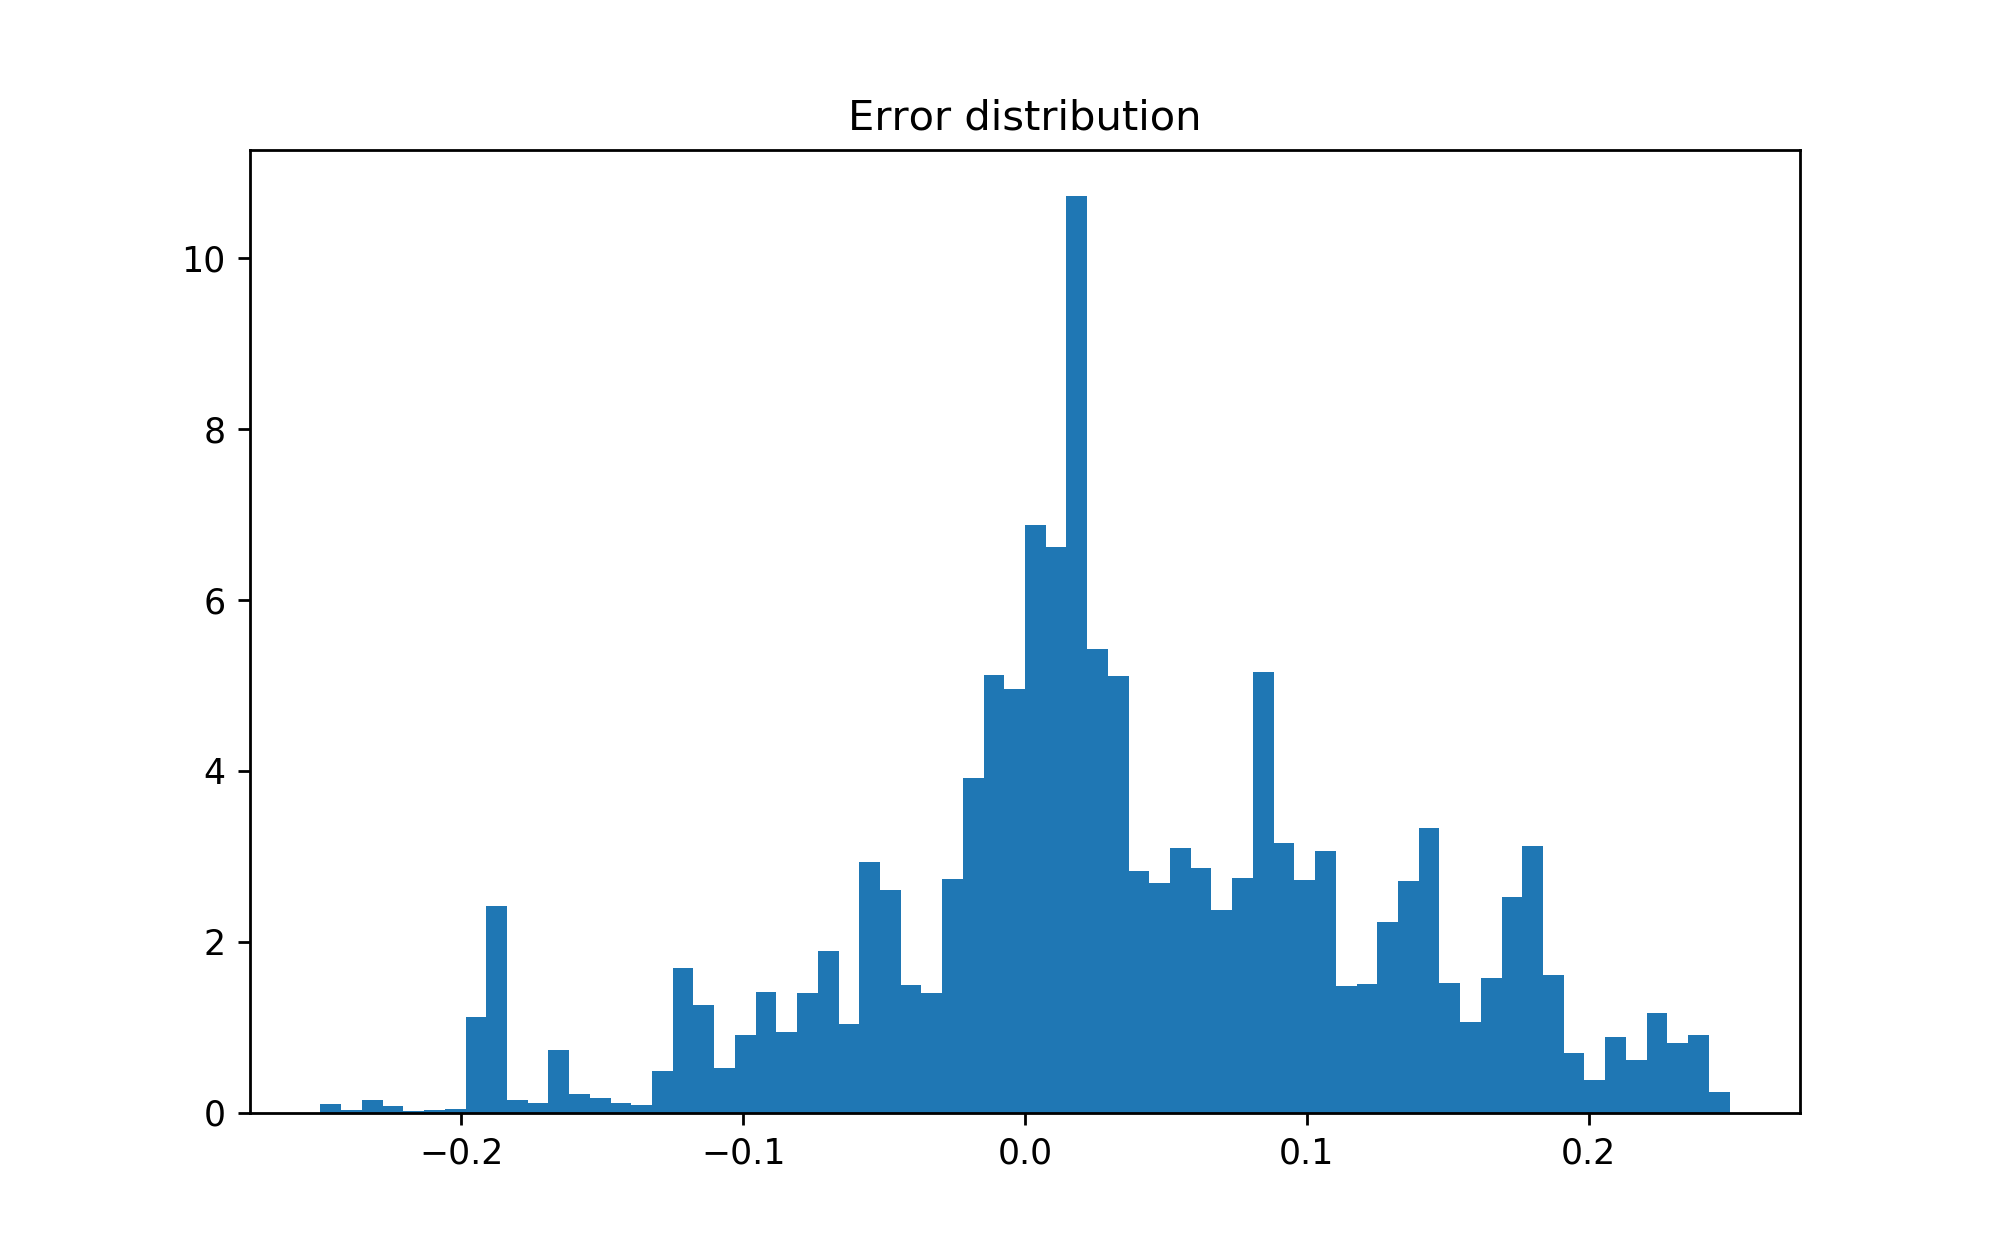

In [22]:
Y_test = data[~rcond]
T_pred = pd.to_datetime(Ypred.timestamp, unit='ms')
T_test = pd.to_datetime(Y_test.timestamp, unit='ms')


for var in output_columns:
    fig, ax = plt.subplots(figsize=(8,5))
    plt.title('Prediction for {}'.format(var))
    ax.plot(T_pred, Ypred[var], '-',label='predict')
    ax.plot(T_test, Y_test[var], '-',label='TRUE')
    ax.legend()
    ax2 = ax.twinx()
    ax2.plot(T_test, Ypred[var].values-Y_test[var].values,'--', color='green', label='Error')
    ax2.legend()
    

fig, ax = plt.subplots(figsize=(8,5))
plt.title('Error distribution')
var = 'SKAP_18FI381-VFlLGas/Y/10sSAMP|average'
A = ax.hist(get_E(Ypred[var],Y_test[var]), bins='auto', range=[-0.25,0.25], density=1)
